In [1]:
import sys
import os
import geopandas as gpd
import pandas as pd
import numpy as np

sys.path.append(os.path.abspath(os.path.join(os.pardir)))

from VASA import VASA

In [2]:
cbg_data = pd.read_csv("../data/sg_cbg.csv")

In [3]:
selected_county_data = cbg_data[[c in [6037] for c in cbg_data["county_fips"]]][["distance_traveled_from_home", "cbg_fips", "date_range_start"]]
selected_county_data["fips"] = ["0" + str(f) for f in selected_county_data["cbg_fips"]]

In [4]:
selected_county_data

,distance_traveled_from_home,cbg_fips,date_range_start,fips
5,3445.0,60371012201,2019-12-21 08:00:00+00:00,060371012201
6,2332.0,60371066452,2019-12-21 08:00:00+00:00,060371066452
7,4929.0,60371210102,2019-12-21 08:00:00+00:00,060371210102
8,3385.0,60371342012,2019-12-21 08:00:00+00:00,060371342012
9,1031.0,60371959011,2019-12-21 08:00:00+00:00,060371959011
...,...,...,...,...
7294962,2086.0,60374033051,2020-11-11 08:00:00+00:00,060374033051
7294963,2412.0,60375041011,2020-11-11 08:00:00+00:00,060375041011
7294964,1822.0,60375736013,2020-11-11 08:00:00+00:00,060375736013
7294965,1393.0,60375740003,2020-11-11 08:00:00+00:00,060375740003


<AxesSubplot:>

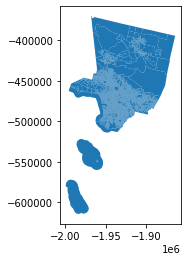

In [5]:
all_counties = gpd.read_file("../data/ca_cbg")
#counties = all_counties[[c in ["037", "111", "029", "059"] for c in all_counties["COUNTYFP"]]]
counties = all_counties[[c in ["037"] for c in all_counties["COUNTYFP"]]] # just LA

counties_map = gpd.GeoDataFrame \
    .from_features(counties) \
    .set_crs(epsg=4326) \
    .to_crs("+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs")

counties_map.plot(linewidth=0)

In [6]:
v = VASA(
    selected_county_data,
    counties_map,
    gdf_group_col="GEOID",
    date_col="date_range_start",
    date_format="%Y-%m-%d %H:%M:%S%z"
)

In [7]:
v.group()

In [8]:
d = np.array(v.df["distance_traveled_from_home"].tolist())

n_total = len(d[0])
n_all_missing = len(d[:, np.all(np.isnan(d), axis=0)][0])

pct_all_missing = n_all_missing / n_total * 100
n_all_missing, pct_all_missing, n_total

(1505, 22.834167804582005, 6591)

<AxesSubplot:>

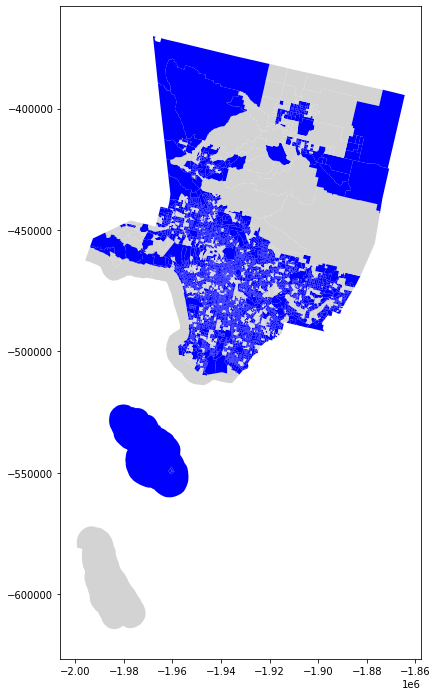

In [9]:
colorMap = pd.DataFrame()

colorMap["fips"] = v.fips_order
colorMap["color"] = [("lightgray" if c else "blue") for c in np.all(np.isnan(d), axis=0)]

merged_map = v.gdf.merge(
    colorMap, left_on="GEOID", right_on="fips"
)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 12))
merged_map.plot(color=merged_map["color"], ax=ax)

In [10]:
n_partial_missing = len(d[:, np.any(np.isnan(d), axis=0)][0]) - n_all_missing

pct_partial_missing = n_partial_missing / n_total * 100
n_partial_missing, pct_partial_missing, n_total

(26, 0.39447731755424065, 6591)

(array([5.060e+03, 1.300e+01, 7.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 1.506e+03]),
 array([0.  , 0.01, 0.1 , 0.2 , 0.4 , 0.6 , 0.8 , 0.9 , 1.  ]),
 <BarContainer object of 8 artists>)

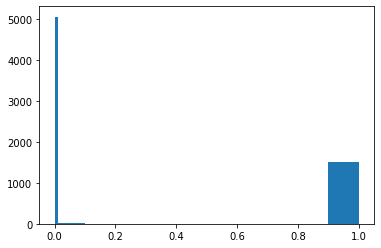

In [11]:
pct_missing_county = np.sum(np.isnan(d.T), axis=1) / d.shape[0]

import matplotlib.pyplot as mpl

mpl.hist(pct_missing_county, bins=[0, 0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 1])

In [12]:
v.lisa()

('WARNING: ', 3544, ' is an island (no neighbors)')


/home/alex/Desktop/github/VASA/myenv/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There is 1 island with id: 3544.
  warnings.warn(message)


ValueError: cannot assign slice from input of different size

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

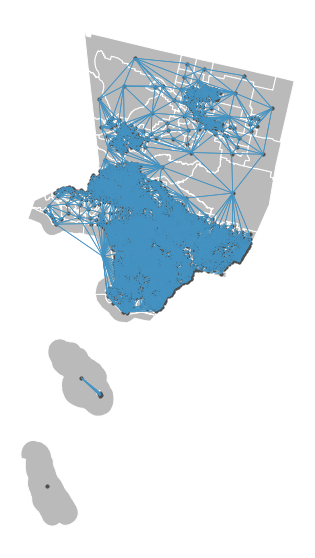

In [13]:
# Queens weights
from splot.libpysal import plot_spatial_weights
plot_spatial_weights(v.W, v.gdf)

/home/alex/Desktop/github/VASA/myenv/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


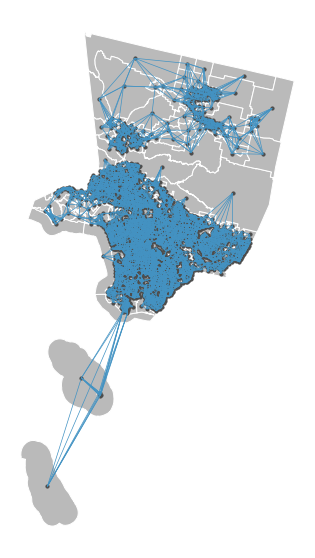

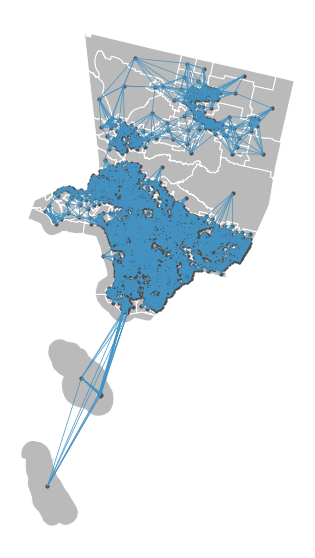

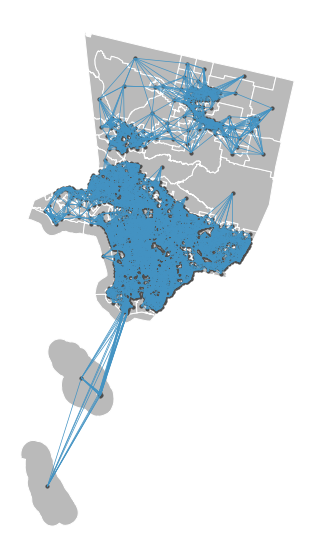

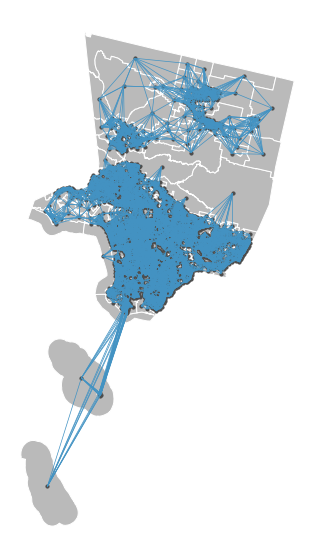

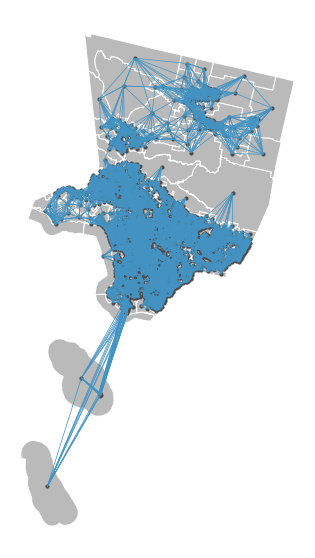

In [14]:
#KNN
import libpysal as lps

for k in [6, 7, 8, 9, 10]:
    W = lps.weights.KNN.from_dataframe(v.gdf, "geometry", k=k)
    plot_spatial_weights(W, v.gdf)

islands:  [3544]


/home/alex/Desktop/github/VASA/myenv/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


attached islands: [] {3529: 1.0}


(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

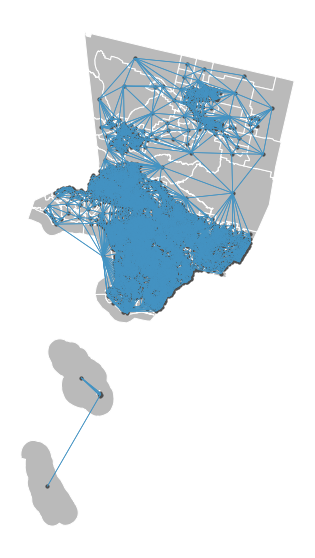

In [15]:
# ATTACH ISLANDS
import libpysal as lbs

w = v.W
print("islands: ", w.islands)

w_knn = lps.weights.KNN.from_dataframe(v.gdf, "geometry", k=5)
w_attach = lps.weights.attach_islands(w, w_knn)

print("attached islands:", w_attach.islands, w_attach[w.islands[0]])
plot_spatial_weights(w_attach, v.gdf)

In [18]:
v.impute()

d = np.array(v.df["distance_traveled_from_home"].tolist())
n_partial_missing = len(d[:, np.any(np.isnan(d), axis=0)][0])
n_partial_missing

0

In [22]:
v.lisa(k=7)

ValueError: dimension mismatch

In [ ]:
from sklearn.impute import SimpleImputer

test = np.array([
    [1, 2, 3, np.nan],
    [2, 3, 4, 1],
    [1, 2, 3, 4]
])

print(test)

imp_mean = SimpleImputer(missing_values=np.nan, strategy="mean")
imp_mean.fit_transform(test)

[[ 1.  2.  3. nan]
 [ 2.  3.  4.  1.]
 [ 1.  2.  3.  4.]]


array([[1. , 2. , 3. , 2.5],
       [2. , 3. , 4. , 1. ],
       [1. , 2. , 3. , 4. ]])

In [ ]:
test = pd.DataFrame()

test["a"] = np.array(v.df["distance_traveled_from_home"].tolist()).tolist()
test

,a
0,"[1367.5, 4092.5, 2265.5, 2316.0, 2260.5, 3076...."
1,"[1902.4285714285713, 4788.142857142857, 2710.7..."
2,"[4078.5714285714284, 7353.285714285715, 6134.2..."
3,"[5761.142857142857, 7709.714285714285, 7248.42..."
4,"[7345.428571428572, 8198.42857142857, 4990.857..."
5,"[6636.142857142857, 9421.0, 5271.285714285715,..."
6,"[5755.857142857143, 8825.57142857143, 6818.428..."
7,"[7127.142857142857, 7782.714285714285, 8672.14..."
8,"[6823.285714285715, 8229.0, 7771.142857142857,..."
9,"[6673.0, 10280.285714285714, 7399.857142857143..."
